# Farm-Field relationship

## Supposed Pre-registration
**1) Have any data been collected for this study already?**
Yes
**2) What's the main question being asked or hypothesis being tested in this study?**
The structure and changes in structure of fields, i.e., size, shape and number of fields within an agricultural landscape boundary are influenced by factors which can be external or farm-related. The external factors include natural distribution of ecosystems (e.g., rivers, forests, etc.) as well as institutional processes such as placements of infrastructures (roads, buildings, etc.) and regulations which may, directly or indirectly through farmer's decision, influence field structures. Ecosystems and infrastructures will strongly influence the structure and change in structures of fields proximate to them while regulations, for example, change in a biodiversity policy may cause field structures to change so as to increase ecosystem diversity and the broader landscape configuration. Therefore, the influence of external factors on fields can be considered to indirectly emerge in the process of these external factors shaping landscape configuration.

On the other hand, farm-related factors such as farm specialisation, change in management technique, technology usage, farm consolidation and fragmentation directly involve or lead to change field structure. So much so that concepts describing field structure e.g., field size are sometimes assumed to be implied from concepts such as farm size which describe farm structure. 

In this study, we seek to examine how change in farm size as an aspect of farm structural change relates to change in field size. That is, is it correct to imply a positive relationship between farm size and field size change?

**3) Describe the key dependent variable(s) specifying how they will be measured.**
Yearly change in field size. Measure by computing relative difference in field size for every subsequent year. I.e., FSy2 - FSy1 /FSy1

**4) How many and which conditions will participants be assigned to?**
Not applicable

**5) Specify exactly which analyses you will conduct to examine the main question/hypothesis.**
We test if there is a proportionate positive relationship between farm size change and field size change.

We empirically estimate the following model to test the hypothesis:  
∆[AFiS_it]=β_0+β_1 ∆[AFaS_it]+α_i+ε_it  ... (m1)

or

∆[AFiS_it]=α_i+β_1 ∆[AFaS_it]++ε_it     ... (m2)


AFiS_it is a random variable of the average field size in a grid cell in time t and ∆[AFiS_it] is the magnitude for which AFiS_i in year t differs from AFiS_i in year t - 1.
AFaS_it is a random variable of the average farm size in a grid cell in time t and ∆[AFaS_it] is the magnitude for which AFaS_i in year t differs from AFaS_i in year t - 1.
For ∆[AFiS_it], grid cells have unique values because we were able to compute AFiS_it and ∆[AFiS_it] from field level polygons for all districts of Lower Saxony. However, grid cells belonging to X districts all take the district ∆[AFaS_it] averages as values because we used district aggregated farm data.

α_i is a dummy variable of grid cell which characteristics that vary between grid cells but do not change over the studied time period, e.g., grid cell location and predominant land-use in the grid cell location.

In m1 which we use for frequentist linear models, β_0 provides a common intercept and α_i provides individual deviations from this intercept for all gridcells. Therefore actual intercept of each cell can be computed by taking the values from the intercept + α_i value.

In m2, common intercept is computed implicitly for Bayesian application.

**6) Describe exactly how outliers will be defined and handled, and your precise rule(s) for excluding observations.**  **7) How many observations will be collected or what will determine sample size?**
Since this is a regional heterogeneous studies and we have more areas covered in the field data than farm data, we work with all available regions in the farm data and drop regions where data is missing. Therefore, the sample size is the total sum of grid cells in the 'selected' regions.

***

__Import packages__

***

In [156]:
# Required imports
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import openpyxl
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS

import arviz as az
import jax 
from jax import random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.diagnostics import print_summary

# Set seed for reproducibility
rng_key = random.PRNGKey(1)
np.random.seed(0)

***

__*Preparation*: Import and process farm data__

***

In [157]:
os.chdir("C:/Users/aladesuru/Documents/DataAnalysis/Lab/Niedersachsen")
# Load the farm file into a DataFrame
farmdata = pd.read_excel("data/raw/farmdata/farmNieder_corre.xlsx")
farmdata.info()
farmdata.head()

# count unique years in the dataset
farmdata['year'].nunique()
farmdata['LANDKREIS'].nunique()

#check for missing values
farmdata.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LK         1104 non-null   int64  
 1   LANDKREIS  1104 non-null   object 
 2   klasse     1104 non-null   object 
 3   year       1104 non-null   int64  
 4   anzahl     1097 non-null   float64
 5   LF_ha      1066 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 51.9+ KB


LK            0
LANDKREIS     0
klasse        0
year          0
anzahl        7
LF_ha        38
dtype: int64

In [158]:
#subset the data for where klasse is Ingesamt
farmdata_ge = farmdata[farmdata['klasse'] == 'Insgesamt']
print('shape all',farmdata_ge.shape)

# drop rows where LK = 0 i.e. Niedersachsen as a whole
farmdata_ge = farmdata_ge[farmdata_ge['LK'] != 0]
print('shape without whole niedersachsen rows',farmdata_ge.shape)
farmdata_ge.info()
farmdata_ge['LANDKREIS'].nunique()


shape all (138, 6)
shape without whole niedersachsen rows (135, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 135 entries, 8 to 1096
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LK         135 non-null    int64  
 1   LANDKREIS  135 non-null    object 
 2   klasse     135 non-null    object 
 3   year       135 non-null    int64  
 4   anzahl     135 non-null    float64
 5   LF_ha      135 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 7.4+ KB


45

In [159]:
# Convert column dtypes to appropriate types
farmdata_ge['LK'] = farmdata_ge['LK'].astype(object)

In [160]:
# create a new column 'LF_mean' which is 'LF_ha' divided by 'anzahl'
farmdata_ge['LF_mean'] = farmdata_ge['LF_ha'] / farmdata_ge['anzahl']
farmdata_ge.head()

,LK,LANDKREIS,klasse,year,anzahl,LF_ha,LF_mean
8,101,Stadt Braunschweig (kreisfrei),Insgesamt,2010,77.0,6661.0,86.506494
16,102,Stadt Salzgitter (kreisfrei),Insgesamt,2010,104.0,10580.0,101.730769
24,103,Stadt Wolfsburg (kreisfrei),Insgesamt,2010,94.0,8396.0,89.319149
32,151,Gifhorn,Insgesamt,2010,896.0,75710.0,84.497768
40,153,Goslar,Insgesamt,2010,314.0,27675.0,88.136943


In [161]:
from src.analysis.region import regiongdf_df as reg
fdg_ext = reg.calculate_yearlydiff(farmdata_ge)

''' examine the diff columns e.g., using the year diff columns o ensure that the function works as expected'''
fdg_ext[['LK', 'klasse', 'year', 'year_yearly_diff', 'year_yearly_percdiff']].head(10)

,LK,klasse,year,year_yearly_diff,year_yearly_percdiff
272,451,Insgesamt,2010,0.0,0.000000
640,451,Insgesamt,2016,6.0,0.298507
1008,451,Insgesamt,2020,4.0,0.198413
280,452,Insgesamt,2010,0.0,0.000000
648,452,Insgesamt,2016,6.0,0.298507
1016,452,Insgesamt,2020,4.0,0.198413
144,351,Insgesamt,2010,0.0,0.000000
512,351,Insgesamt,2016,6.0,0.298507
880,351,Insgesamt,2020,4.0,0.198413
288,453,Insgesamt,2010,0.0,0.000000


In [162]:
# drop columns LK, klasse, year_yearly_diff, year_yearly_percdiff  
fdg_ext = fdg_ext.drop(columns=['LK', 'klasse', 'year_yearly_diff', 'year_yearly_percdiff'])
# sort by year
fdg_ext = fdg_ext.sort_values(by='year').reset_index(drop=True)
fdg_ext.head()

,LANDKREIS,year,anzahl,LF_ha,LF_mean,anzahl_yearly_diff,anzahl_yearly_percdiff,LF_ha_yearly_diff,LF_ha_yearly_percdiff,LF_mean_yearly_diff,LF_mean_yearly_percdiff
0,Ammerland,2010,1008.0,43611.0,43.264881,0.0,0.0,0.0,0.0,0.0,0.0
1,Aurich,2010,1431.0,80236.0,56.069881,0.0,0.0,0.0,0.0,0.0,0.0
2,Celle,2010,663.0,51166.0,77.173454,0.0,0.0,0.0,0.0,0.0,0.0
3,Cloppenburg,2010,2010.0,93577.0,46.555721,0.0,0.0,0.0,0.0,0.0,0.0
4,Cuxhaven,2010,2070.0,134870.0,65.154589,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
'''Since field data is from 2012 to 2023, for missing yearly data between 2010 and 2023,
let 2010 data be used for 2011 and 2012, 2016 data for 2013 to 2015, and 2020 data for 2017 to 2023'''
# Create a list to store all DataFrames
all_dfs = [fdg_ext]

# Define the years to copy data for
years_to_copy = {2010: range(2011, 2013), 2016: range(2013, 2016), 2020: list(range(2017, 2020)) + list(range(2021, 2024))}

# Loop through the years and create copies
for base_year, copy_years in years_to_copy.items():
    base_data = fdg_ext[fdg_ext['year'] == base_year].copy()
    for year in copy_years:
        df_copy = base_data.copy()
        df_copy['year'] = year
        all_dfs.append(df_copy)

# Concatenate all DataFrames
fdg_ext_all = pd.concat(all_dfs, ignore_index=True)

# Sort the DataFrame by year
fdg_ext_all = fdg_ext_all.sort_values(by='year').reset_index(drop=True)

# print unique years in the dataset
print(fdg_ext_all['year'].unique())

[2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


In [164]:
# drop rows for years 2010 and 2011 in df_farm since we now have 2012 which is a coherent baseyear with field data
fdg_ext_all = fdg_ext_all[fdg_ext_all["year"] > 2011]

# print unique years in the dataset
print(fdg_ext_all['year'].unique())

[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


In [165]:
# drop LANDKREIS "Stadt Oldenburg (Oldb) (kreisfrei)" because this is missing in field data
fdg_ext_all = fdg_ext_all[fdg_ext_all['LANDKREIS'] != 'Stadt Oldenburg (Oldb) (kreisfrei)']
fdg_ext_all['LANDKREIS'].nunique()

44

***

__*Preparation*: Import field data and merge to farm data__

***

In [166]:
from src.analysis.desc import gridgdf_desc as gd

# %% load data
_, gridgdf = gd.silence_prints(gd.create_gridgdf)
# I always want to load gridgdf and process clean gridgdf separately so I can have uncleeaned data for comparison or sensitivity analysis
gridgdf_cl, _ = gd.clean_gridgdf(gridgdf)

2025-02-20 19:43:41,834 - INFO - Unique CELLCODES with fields < 300: 62
2025-02-20 19:43:41,855 - INFO - Final unique CELLCODES in outliers: 57


In [167]:
# drop columns and Landkreise not in farm data from gridgdf_cl
# Specify the columns to keep
columns_to_keep = [
    'geometry', 'LANDKREIS', 'year', 'mfs_ha', 'fsha_sum', 'fields', 'CELLCODE', 'medfs_ha',
    'fields_yearly_percdiff', 'fields_yearly_diff', 'medfs_ha_yearly_diff', 'medfs_ha_yearly_percdiff',
    'fsha_sum_yearly_diff', 'fsha_sum_yearly_percdiff', 'mfs_ha_yearly_diff', 'mfs_ha_yearly_percdiff'
]

# Drop all other columns
field_grids = gridgdf_cl[columns_to_keep]

field_grids = field_grids[~field_grids["LANDKREIS"].isin(["Küstenmeer Region Lüneburg", "Küstenmeer Region Weser-Ems"])]
print('total regions in field data', field_grids['LANDKREIS'].nunique())
field_grids.info()

total regions in field data 44
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6036 entries, 0 to 6155
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   geometry                  6036 non-null   geometry
 1   LANDKREIS                 6036 non-null   object  
 2   year                      6036 non-null   int32   
 3   mfs_ha                    6036 non-null   float64 
 4   fsha_sum                  6036 non-null   float64 
 5   fields                    6036 non-null   int64   
 6   CELLCODE                  6036 non-null   object  
 7   medfs_ha                  6036 non-null   float64 
 8   fields_yearly_percdiff    6036 non-null   float64 
 9   fields_yearly_diff        6036 non-null   float64 
 10  medfs_ha_yearly_diff      6036 non-null   float64 
 11  medfs_ha_yearly_percdiff  6036 non-null   float64 
 12  fsha_sum_yearly_diff      6036 non-null   float64 
 13  fsha_sum_yearl

In [168]:
# %%
# Standardize 'LANDKREIS' column in both DataFrames
df_farm = fdg_ext_all.copy()
df_field = field_grids.copy()

df_field["LANDKREIS"] = df_field["LANDKREIS"].str.strip()
df_farm["LANDKREIS"] = df_farm["LANDKREIS"].str.strip()

# Get unique LANDKREIS values from both DataFrames
farm_landkreise = set(df_farm["LANDKREIS"].unique())
field_landkreise = set(df_field["LANDKREIS"].unique())

# Check if they are the same
if farm_landkreise == field_landkreise:
    print("✅ LANDKREIS values in df_farm and df_field match exactly!")
else:
    print("❌ There are differences in LANDKREIS values between the two DataFrames.")
    
    # Find mismatched values
    only_in_farm = farm_landkreise - field_landkreise
    only_in_field = field_landkreise - farm_landkreise
    
    print(f"⚠️ Present in df_farm but missing in df_field: {only_in_farm}")
    print(f"⚠️ Present in df_field but missing in df_farm: {only_in_field}")


❌ There are differences in LANDKREIS values between the two DataFrames.
⚠️ Present in df_farm but missing in df_field: {'Hannover,Region'}
⚠️ Present in df_field but missing in df_farm: {'Region Hannover'}


In [169]:
# there is inconsistency in naming Hannover region. Therefore:
df_farm["LANDKREIS"] = df_farm["LANDKREIS"].replace("Hannover,Region", "Region Hannover")

# Get unique LANDKREIS values from both DataFrames
farm_landkreise = set(df_farm["LANDKREIS"].unique())
field_landkreise = set(df_field["LANDKREIS"].unique())

# Check if they are the same
if farm_landkreise == field_landkreise:
    print("✅ LANDKREIS values in df_farm and df_field match exactly!")
else:
    print("❌ There are differences in LANDKREIS values between the two DataFrames.")
    
    # Find mismatched values
    only_in_farm = farm_landkreise - field_landkreise
    only_in_field = field_landkreise - farm_landkreise
    
    print(f"⚠️ Present in df_farm but missing in df_field: {only_in_farm}")
    print(f"⚠️ Present in df_field but missing in df_farm: {only_in_field}")


✅ LANDKREIS values in df_farm and df_field match exactly!


In [170]:
df_farm.info()
df_field.info()

<class 'pandas.core.frame.DataFrame'>
Index: 528 entries, 90 to 629
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LANDKREIS                528 non-null    object 
 1   year                     528 non-null    int64  
 2   anzahl                   528 non-null    float64
 3   LF_ha                    528 non-null    float64
 4   LF_mean                  528 non-null    float64
 5   anzahl_yearly_diff       528 non-null    float64
 6   anzahl_yearly_percdiff   528 non-null    float64
 7   LF_ha_yearly_diff        528 non-null    float64
 8   LF_ha_yearly_percdiff    528 non-null    float64
 9   LF_mean_yearly_diff      528 non-null    float64
 10  LF_mean_yearly_percdiff  528 non-null    float64
dtypes: float64(9), int64(1), object(1)
memory usage: 49.5+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6036 entries, 0 to 6155
Data columns (total 16 columns):
 #   Column             

In [171]:
# merge df_farm and df_field using the LANDKREIS and year columns, inner join
farm_field = df_farm.merge(df_field, on=["LANDKREIS", "year"])

farm_fielddf = pd.DataFrame(farm_field)
farm_fielddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036 entries, 0 to 6035
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   LANDKREIS                 6036 non-null   object  
 1   year                      6036 non-null   int64   
 2   anzahl                    6036 non-null   float64 
 3   LF_ha                     6036 non-null   float64 
 4   LF_mean                   6036 non-null   float64 
 5   anzahl_yearly_diff        6036 non-null   float64 
 6   anzahl_yearly_percdiff    6036 non-null   float64 
 7   LF_ha_yearly_diff         6036 non-null   float64 
 8   LF_ha_yearly_percdiff     6036 non-null   float64 
 9   LF_mean_yearly_diff       6036 non-null   float64 
 10  LF_mean_yearly_percdiff   6036 non-null   float64 
 11  geometry                  6036 non-null   geometry
 12  mfs_ha                    6036 non-null   float64 
 13  fsha_sum                  6036 non-null   float6

In [172]:
farm_field['LANDKREIS'].nunique()

44

In [173]:
# Get unique LANDKREIS values from both DataFrames
farm_landkreise = set(df_farm["LANDKREIS"].unique())
field_landkreise = set(df_field["LANDKREIS"].unique())
farm_field_landkreise = set(farm_field["LANDKREIS"].unique())

# Check if they are the same
if farm_landkreise == field_landkreise == farm_field_landkreise:
    print("✅ LANDKREIS values in df_farm, df_field and farm_field match exactly!")
else:
    print("❌ There are differences in LANDKREIS values between the two DataFrames.")
    
    # Find mismatched values
    only_in_farm = farm_landkreise - field_landkreise - farm_field_landkreise
    only_in_field = field_landkreise - farm_landkreise - farm_field_landkreise
    only_in_farm_field = farm_field_landkreise - field_landkreise - farm_landkreise
    
    print(f"⚠️ Present in df_farm but missing in df_field and farm_field: {only_in_farm}")
    print(f"⚠️ Present in df_field but missing in df_farm and farm_field: {only_in_field}")
    print(f"⚠️ Present in farm_field but missing in df_farm and df_field: {only_in_farm_field}")
    
    

✅ LANDKREIS values in df_farm, df_field and farm_field match exactly!


In [174]:
# drop 2012 data from farm_field because of 0 values
farm_field = farm_field[farm_field["year"] != 2012]
farm_field['year'].nunique()

11

***

## Modelling

***

## Classical

We specify a **scientific model** with fixed entity effects

$\Delta AFiS_{it} = \beta_0 + \beta_1 \Delta AFaS_{it} + \alpha_i + \varepsilon_{it}$

where:  
- $ \Delta AFiS_{it} $ = Differenced dependent variable  
- $ \Delta AFaS_{it} $ = Differenced independent variable (regressor)
- $ \beta_0 $ = Common intercept      
- $ \alpha_i $ = Entity-fixed characteristics    
- $ \varepsilon_{it} $ = Error term 
- $ i $ = Individual grid cells
- $ t $ = Time


In [20]:
# Group by 'year' and calculate the mean of 'medfs_ha_yearly_percdiff' for each year
yearly_mean = farm_field.groupby('year')['medfs_ha_yearly_percdiff'].mean()

# Print the result
print("Yearly Mean of medfs_ha_yearly_percdiff:")
print(yearly_mean)

Yearly Mean of medfs_ha_yearly_percdiff:
year
2013    0.750059
2014    0.354362
2015   -1.673725
2016    1.610102
2017   -0.991462
2018   -1.582835
2019    0.740496
2020   -0.648280
2021   -0.245012
2022    0.269061
2023    0.889860
Name: medfs_ha_yearly_percdiff, dtype: float64


***
__*First*: Run a simple pooled OLS__

***
i.e.,


$\Delta AFiS_{it} = \beta_0 + \beta_1 \Delta AFaS_{it} + \varepsilon_{it}$


In [175]:
# first run the regression without fixed effects using smf.ols or linearmodels
df = farm_field.copy()

df = df.set_index(["CELLCODE", "year"])
mod = smf.ols('medfs_ha_yearly_percdiff ~ LF_mean_yearly_percdiff', data=df).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.6846,0.082,-8.398,0.000,-0.844,-0.525
LF_mean_yearly_percdiff,0.0825,0.009,8.960,0.000,0.064,0.101


In [176]:
# run thesame model with linearmodels just to compare modules
from linearmodels.panel import PanelOLS

mod = PanelOLS.from_formula("medfs_ha_yearly_percdiff ~ 1 + LF_mean_yearly_percdiff", data=df)

res = mod.fit()
res.summary


Dep. Variable:,medfs_ha_yearly_percdiff,R-squared:,0.0143
Estimator:,PanelOLS,R-squared (Between):,0.1241
No. Observations:,5533,R-squared (Within):,0.0044
Date:,"Thu, Feb 20 2025",R-squared (Overall):,0.0143
Time:,19:45:05,Log-likelihood,-1.388e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,80.288
Entities:,503,P-value,0.0000
Avg Obs:,11.000,Distribution:,"F(1,5531)"
Min Obs:,11.000,,
Max Obs:,11.000,F-statistic (robust):,80.288


***
__*Now*: We run FE models starting with the afore-specified entity effect model__

***



#### Entity fixed effects model

In [65]:
#manually demean the variables for entity fixed effects
demeaned = farm_field.copy()


demeaned["X_demeaned"] = demeaned["LF_mean_yearly_percdiff"] - demeaned.groupby("CELLCODE")["LF_mean_yearly_percdiff"].transform("mean")
demeaned["Y_demeaned"] = demeaned["medfs_ha_yearly_percdiff"] - demeaned.groupby("CELLCODE")["medfs_ha_yearly_percdiff"].transform("mean")

In [42]:
# Define the variables
X = "X_demeaned"
Y = "Y_demeaned"

# Fit the OLS model
mod = smf.ols(f"{Y} ~ {X}", data=demeaned).fit()
#mod.summary()
print(mod.summary())


                            OLS Regression Results                            
Dep. Variable:             Y_demeaned   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     28.45
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           1.00e-07
Time:                        15:05:32   Log-Likelihood:                -13664.
No. Observations:                5533   AIC:                         2.733e+04
Df Residuals:                    5531   BIC:                         2.734e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8.109e-17      0.038  -2.11e-15      1.0

In [43]:
# use linearmodel modules to run the fixed effects regression
df = farm_field.copy()

fe_model1 = smf.ols("medfs_ha_yearly_percdiff ~ LF_mean_yearly_percdiff + C(CELLCODE)", data=df).fit()
print(fe_model1.summary())


                               OLS Regression Results                               
Dep. Variable:     medfs_ha_yearly_percdiff   R-squared:                       0.087
Model:                                  OLS   Adj. R-squared:                 -0.004
Method:                       Least Squares   F-statistic:                    0.9576
Date:                      Thu, 20 Feb 2025   Prob (F-statistic):              0.736
Time:                              15:35:21   Log-Likelihood:                -13664.
No. Observations:                      5533   AIC:                         2.834e+04
Df Residuals:                          5029   BIC:                         3.167e+04
Df Model:                               503                                         
Covariance Type:                  nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [ ]:
# we can extract the coefficients of each entity and calculate with intercept to get the actual entity coefficients
entity_effects = fe_model1.params.filter(like="C(CELLCODE)", axis=0)
# put in df
entity_effects = entity_effects.reset_index()
entity_effects.columns = ["CELLCODE", "entity_effect"]

# Calculate the actual entity coefficients
entity_effects["entity_coefficient"] = entity_effects["entity_effect"] + fe_model1.params["Intercept"]

# Edit values in the 'CELLCODE' column to only contain the last 13 characters
entity_effects['CELLCODE'] = entity_effects['CELLCODE'].str.slice(-13)
# Further edit values in the 'CELLCODE' column to retain only the first 12 characters
entity_effects['CELLCODE'] = entity_effects['CELLCODE'].str.slice(0, 12)

# Print the result
print(entity_effects.head())

                      CELLCODE  entity_effect  entity_coefficient
0  C(CELLCODE)[T.10kmE410N327]      -0.104693           -0.711448
1  C(CELLCODE)[T.10kmE410N328]       0.061416           -0.545339
2  C(CELLCODE)[T.10kmE411N326]       0.187258           -0.419496
3  C(CELLCODE)[T.10kmE411N327]       0.550460           -0.056295
4  C(CELLCODE)[T.10kmE411N328]       1.274405            0.667650


In [30]:
from linearmodels.panel import PanelOLS
df = farm_field.copy()

df = df.set_index(["CELLCODE", "year"])
fe_model = PanelOLS.from_formula("medfs_ha_yearly_percdiff ~ 1 + LF_mean_yearly_percdiff + EntityEffects", data=df)
fe_model2 = fe_model.fit(cov_type='clustered', cluster_entity=True)
fe_model2.summary

Dep. Variable:,medfs_ha_yearly_percdiff,R-squared:,0.0051
Estimator:,PanelOLS,R-squared (Between):,0.1035
No. Observations:,5533,R-squared (Within):,0.0051
Date:,"Tue, Feb 18 2025",R-squared (Overall):,0.0133
Time:,10:45:31,Log-likelihood,-1.366e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,25.867
Entities:,503,P-value,0.0000
Avg Obs:,11.000,Distribution:,"F(1,5029)"
Min Obs:,11.000,,
Max Obs:,11.000,F-statistic (robust):,34.316


***
How about a time fixed effect model where we $\alpha_i $ represents entity invariant characteristics that change over time.
***

In [28]:
df = farm_field.copy()

df = df.set_index(["CELLCODE", "year"])
mod = PanelOLS.from_formula("medfs_ha_yearly_percdiff ~ 1 + LF_mean_yearly_percdiff + TimeEffects", data=df)

fe_model3 = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
fe_model3.summary

Dep. Variable:,medfs_ha_yearly_percdiff,R-squared:,0.0094
Estimator:,PanelOLS,R-squared (Between):,0.1270
No. Observations:,5533,R-squared (Within):,0.0041
Date:,"Tue, Feb 18 2025",R-squared (Overall):,0.0143
Time:,10:42:35,Log-likelihood,-1.355e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,52.303
Entities:,503,P-value,0.0000
Avg Obs:,11.000,Distribution:,"F(1,5521)"
Min Obs:,11.000,,
Max Obs:,11.000,F-statistic (robust):,34.668


***
And Time & entity fixed effects?
***
Not great. B = 0.0004 and P-value = 0.9784

***
Random effect?
***
Result is same as pooled OLS.



In [31]:
from linearmodels.panel import RandomEffects

# RE model
model = RandomEffects.from_formula("medfs_ha_yearly_percdiff ~ 1 + LF_mean_yearly_percdiff", data=df)

re_model = model.fit()

re_model.summary

Dep. Variable:,medfs_ha_yearly_percdiff,R-squared:,0.0143
Estimator:,RandomEffects,R-squared (Between):,0.1241
No. Observations:,5533,R-squared (Within):,0.0044
Date:,"Tue, Feb 18 2025",R-squared (Overall):,0.0143
Time:,10:45:39,Log-likelihood,-1.388e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,80.288
Entities:,503,P-value,0.0000
Avg Obs:,11.000,Distribution:,"F(1,5531)"
Min Obs:,11.000,,
Max Obs:,11.000,F-statistic (robust):,80.288


***
### Hausman test
***

Entity effects adjusted for entity clustering has the best Hausman P-value for a Fixed Effects model when we compare the entity effect model above fe_model2 and time effect model fe_model3 with Random Effect model.

Therefore, if we want to use FE, we use model 2 and otherwise use pooled OLS whose result is basically thesame as RE.

In [32]:
# Get FE and RE coefficients
b_fe = fe_model2.params
b_re = re_model.params

# Get variance-covariance matrices
V_fe = fe_model2.cov
V_re = re_model.cov

# Compute the difference in coefficients
b_diff = b_fe - b_re

# Compute the covariance difference
V_diff = V_fe - V_re

# Compute the Hausman test statistic
from scipy.stats import chi2

# Hausman statistic
chi2_stat = np.dot(b_diff.T, np.linalg.inv(V_diff)).dot(b_diff)

# Degrees of freedom = number of regressors
df = b_fe.shape[0]

# p-value
p_value = 1 - chi2.cdf(chi2_stat, df)

print(f"Hausman Test Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Reject H0: Fixed Effects (FE) is preferred.")
else:
    print("Fail to reject H0: Random Effects (RE) is preferred.")


Hausman Test Statistic: 24.2768
P-value: 0.0000
Reject H0: Fixed Effects (FE) is preferred.


no Time fixed effects nmodel is preferred to re model. Therefore, I am compelled to go with entity effect model with best hausman p-value (0.0035) i.e, model with entity clustering.

# Bayesian

Here, we run Entity FE the Bayesian way but instead of the afore specification with explicit common intercept, We use an alternative specification with implicit common intercept for all entities.
This would allow easier visulization of variations in intercepts.

$\Delta AFiS_{it} = \alpha_i + \beta \Delta AFaS_{it} + \varepsilon_{it}$

$\Delta AFiS_{it} \sim Normal(\mu_{it}, \sigma) $

$\mu_{it} = \alpha_i + \beta \Delta AFaS_{it} $

$\alpha_i \sim Normal(0, \sigma) $ entity-specific intercept i.e., mean change in A

$\beta \sim Normal(0, 1) $

$\sigma \sim Exponential(1) $

$\alpha_i$ captures systematic differences across entities in how AFiS changes. It represents an entity-level baseline shift in $\Delta AFiS_{it}$ that is not explained by $\beta \Delta AFaS_{it} $.

Its normal prior with mean 0 assumes that, on average, entities have no systematic difference unless the data suggests otherwise. The variance of $\alpha_i$ (driven by $\sigma$) determines how much heterogeneity exists across entities.

# Bayesian 2

Here, we use hyperpriors for $\alpha_i $

$\Delta AFiS_{it} = \alpha_i + \beta \Delta AFaS_{it} + \varepsilon_{it}$

$\Delta AFiS_{it} \sim Normal(\mu_{it}, \sigma) $

$\mu_{it} = \alpha_i + \beta \Delta AFaS_{it} $

$\alpha_i \sim Normal(\mu_i, \sigma_i) $ entity effects

$\beta \sim Normal(0, 10) $

$\mu_i \sim Normal(0, 10) $

$\sigma_i \sim Half-Cauchy(0,2)  $

$\sigma \sim Half-Cauchy(0,2)  $

In [ ]:
demeaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5533 entries, 503 to 6035
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   LANDKREIS                 5533 non-null   object  
 1   year                      5533 non-null   int64   
 2   anzahl                    5533 non-null   float64 
 3   LF_ha                     5533 non-null   float64 
 4   LF_mean                   5533 non-null   float64 
 5   anzahl_yearly_diff        5533 non-null   float64 
 6   anzahl_yearly_percdiff    5533 non-null   float64 
 7   LF_ha_yearly_diff         5533 non-null   float64 
 8   LF_ha_yearly_percdiff     5533 non-null   float64 
 9   LF_mean_yearly_diff       5533 non-null   float64 
 10  LF_mean_yearly_percdiff   5533 non-null   float64 
 11  geometry                  5533 non-null   geometry
 12  mfs_ha                    5533 non-null   float64 
 13  fsha_sum                  5533 non-null   float64 


In [66]:
# Create numeric entity IDs
demeaned["entity_id"] = demeaned["CELLCODE"].astype("category").cat.codes  # Converts strings to numeric IDs
entity_to_cellcode = dict(enumerate(demeaned["CELLCODE"].astype("category").cat.categories))

# Convert to dictionary for NumPyro
data = {
    "entity": demeaned["entity_id"].values,  # Now numeric
    "delta_X": demeaned["X_demeaned"].values,
    "delta_Y": demeaned["Y_demeaned"].values
}
demeaned.shape

(5533, 28)

In [24]:
delta_X = demeaned["X_demeaned"].values
delta_Y = demeaned["Y_demeaned"].values
entity = demeaned["entity_id"].values

# Number of unique entities
num_entities = len(jnp.unique(entity))

***
### STEP 1: DEFINE THE MODEL (Field Size Model)
***

In [25]:
def fieldsize(delta_X, entity, num_entities, delta_Y=None):

    # Priors
    alpha_i = numpyro.sample("alpha_i", dist.Normal(0, 1).expand([num_entities]))  # Entity-specific effects
    beta = numpyro.sample("beta", dist.Normal(0, 1))  # Slope
    sigma = numpyro.sample("sigma", dist.Exponential(1))  # std. deviation
    
    # Mean function using numeric entity index
    mu = alpha_i[entity] + beta * delta_X
    
    # Likelihood
    numpyro.sample("delta_Y", dist.Normal(mu, sigma), obs=delta_Y)
    

In [39]:
# mod2
def fieldsize2(delta_X, entity, num_entities, delta_Y=None):

    # Hierarchical priors
    beta = numpyro.sample("beta", dist.Normal(0, 10))  # Slope
    sigma = numpyro.sample("sigma", dist.HalfCauchy(0.2))  # std. deviation
    mu_i = numpyro.sample("mu_i", dist.Normal(0, 10))  # Mean
    sigma_i = numpyro.sample("sigma_i", dist.HalfCauchy(0.2))  # std. deviation
    alpha_i = numpyro.sample("alpha_i", dist.Normal(mu_i, sigma_i), sample_shape=(num_entities,))  # Entity-specific effects
      
    # Mean function using numeric entity index
    mu_it = alpha_i[entity] + beta * delta_X
    
    # Likelihood
    numpyro.sample("delta_Y", dist.Normal(mu_it, sigma), obs=delta_Y)

***
### STEP 2: SIMULATE PRIOR PREDICTIVE
***

In [26]:
# Simulate observations from prior
nPriorSamples = 100

# Update the random number seed
rng_key, rng_key_ = random.split(rng_key) 
# Use numpyro Predictive() to generate sample from prior
prior_predictive = Predictive(fieldsize, num_samples=nPriorSamples)
prior_samples = prior_predictive(rng_key_,delta_X=delta_X, entity=entity, num_entities=num_entities)


print("Prior predictive samples:", prior_samples.keys())
print('alpha_i.shape',prior_samples['alpha_i'].shape)
print('beta.shape',prior_samples['beta'].shape)
print('sigma.shape',prior_samples['sigma'].shape)
print('delta_Y.shape',prior_samples['delta_Y'].shape)

Prior predictive samples: dict_keys(['alpha_i', 'beta', 'delta_Y', 'sigma'])
alpha_i.shape (100, 503)
beta.shape (100,)
sigma.shape (100,)
delta_Y.shape (100, 5533)


In [40]:
#mod2
# Simulate observations from prior
nPriorSamples = 100

# Update the random number seed
rng_key, rng_key_ = random.split(rng_key) 
# Use numpyro Predictive() to generate sample from prior
prior_predictive = Predictive(fieldsize2, num_samples=nPriorSamples)
prior_samples = prior_predictive(rng_key_,delta_X=delta_X, entity=entity, num_entities=num_entities)


print("Prior predictive samples:", prior_samples.keys())
print('alpha_i.shape',prior_samples['alpha_i'].shape)
print('sigma_i.shape',prior_samples['sigma_i'].shape)
print('mu_i.shape',prior_samples['mu_i'].shape)
print('beta.shape',prior_samples['beta'].shape)
print('sigma.shape',prior_samples['sigma'].shape)
print('delta_Y.shape',prior_samples['delta_Y'].shape)

Prior predictive samples: dict_keys(['alpha_i', 'beta', 'delta_Y', 'mu_i', 'sigma', 'sigma_i'])
alpha_i.shape (100, 503)
sigma_i.shape (100,)
mu_i.shape (100,)
beta.shape (100,)
sigma.shape (100,)
delta_Y.shape (100, 5533)


__In the next steps, remember to change model to fieldsize or fieldsize2 depending on whether you aim to see results according to hierarchical model (mod2, fieldsize2) or the first model.__

<Axes: ylabel='Count'>

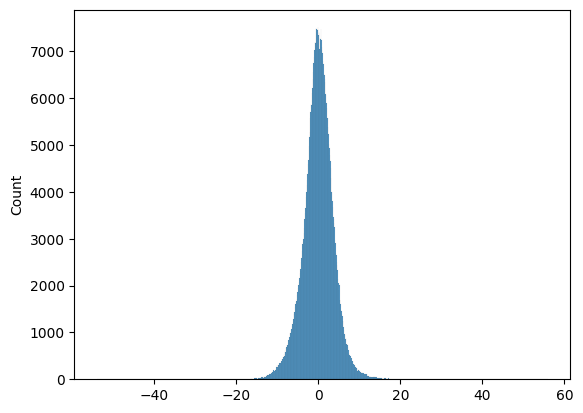

In [27]:
import seaborn as sns
fig,ax=plt.subplots()
sns.histplot(prior_samples['delta_Y'].flatten(),ax=ax)
#ax.set_xlim(-50,300)

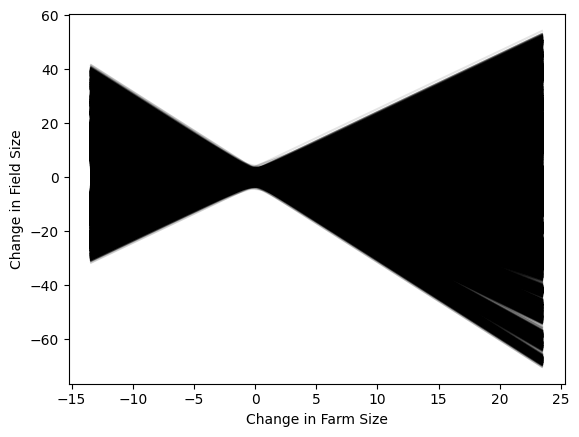

In [ ]:
N_lines = 100  # Number of prior predictive lines

fig, ax = plt.subplots()

# Generate x values for plotting
x = jnp.linspace(delta_X.min(), delta_X.max(), 101)

# Loop over random samples (instead of treating alpha_i as a single value)
for i in range(N_lines):
    for j in range(len(prior_samples['alpha_i'][i])):  # Iterate over entities
        ax.plot(x, prior_samples['alpha_i'][i][j] + prior_samples['beta'][i] * x, "k", alpha=0.1)

ax.set_xlabel("Change in Farm Size")
ax.set_ylabel("Change in Field Size")

plt.show()


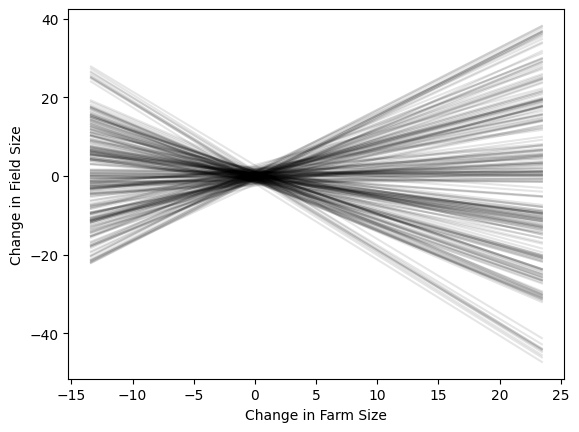

In [28]:
N_lines = 50  # Number of prior predictive lines
N_entities_to_plot = 5  # Choose a subset of entities

fig, ax = plt.subplots()

x = jnp.linspace(delta_X.min(), delta_X.max(), 101)
selected_entities = np.random.choice(len(prior_samples['alpha_i'][0]), N_entities_to_plot, replace=False)

for i in range(N_lines):  # Loop over prior samples
    for j in selected_entities:  # Only plot selected entities
        ax.plot(x, prior_samples['alpha_i'][i][j] + prior_samples['beta'][i] * x, "k", alpha=0.1)

ax.set_xlabel("Change in Farm Size")
ax.set_ylabel("Change in Field Size")
plt.show()

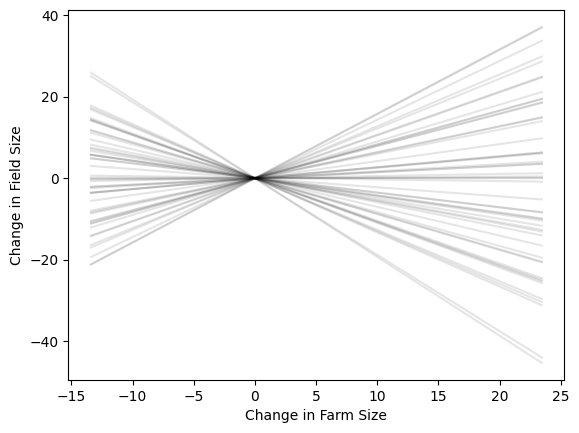

In [29]:
# Average Over Entities
fig, ax = plt.subplots()

x = jnp.linspace(delta_X.min(), delta_X.max(), 101)

for i in range(N_lines):
    alpha_mean = prior_samples['alpha_i'][i].mean()  # Compute the average entity effect
    ax.plot(x, alpha_mean + prior_samples['beta'][i] * x, "k", alpha=0.1)

ax.set_xlabel("Change in Farm Size")
ax.set_ylabel("Change in Field Size")
plt.show()


***
### STEP 3: GENERATE SYNTHETIC DATA
***

delta_Y.shape (5533,)


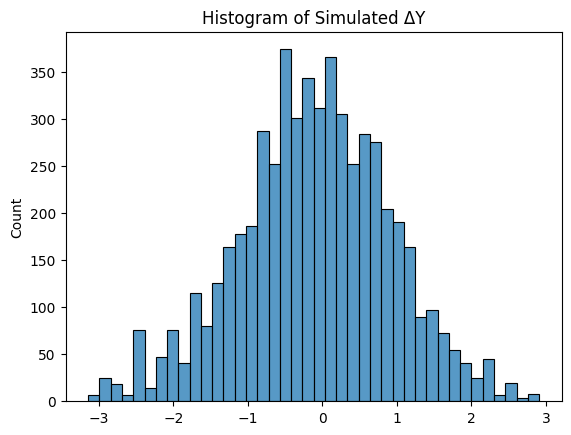

delta_Y.shape: (5533,)
delta_X.shape: (5533,)


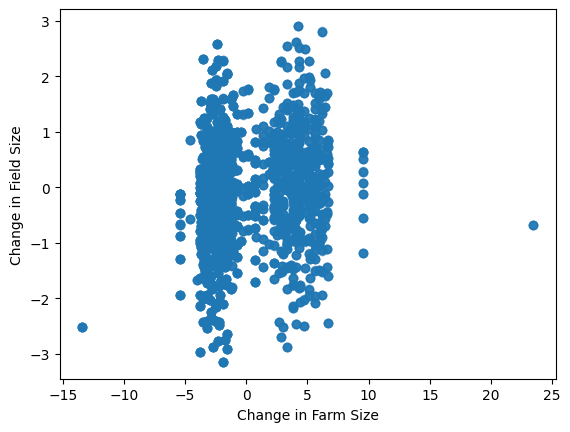

In [ ]:
# Condition the model 
coefTrue = {
            # YOUR CODE HERE
            'alpha_i': jnp.array(np.random.normal(0, 1, num_entities)), 
            'beta': 0.05,
            'sigma': 0.001,
           }
# Use coefTrue to condition the model
condition_model = numpyro.handlers.condition(fieldsize, data=coefTrue)
# Generate synthetic data using conditioned model
conditioned_predictive = Predictive(condition_model, num_samples=1)
condition_samples = conditioned_predictive(rng_key_,delta_X=delta_X, entity=entity, num_entities=num_entities)
condition_samples

# Use the conditioned data to define the outcome variables 
delta_Y = condition_samples['delta_Y'][0]

print('delta_Y.shape',delta_Y.shape)

# Plot the generated data
fig,ax=plt.subplots()
sns.histplot(delta_Y.flatten(), ax=ax)
ax.set_title("Histogram of Simulated ΔY")
plt.show()

fig, ax = plt.subplots()
ax.scatter(delta_X, delta_Y, alpha=0.5)
ax.set_xlabel("Change in Farm Size")
ax.set_ylabel("Change in Field Size")


print(f"delta_Y.shape: {delta_Y.shape}")
print(f"delta_X.shape: {delta_X.shape}")

***
### STEP 4: FIT THE MODEL USING MCMC
first with above stated conditioning and then with real Y data
***

In [30]:
delta_Y_real = demeaned["Y_demeaned"].values

In [32]:
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(fieldsize)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, delta_X=delta_X, entity=entity, delta_Y=delta_Y_real, num_entities=num_entities)

sample: 100%|██████████| 2000/2000 [00:04<00:00, 451.06it/s, 15 steps of size 3.11e-01. acc. prob=0.85]


***
### STEP 5: ANALYZE POSTERIOR DISTRIBUTIONS
***

In [33]:
azMCMC = az.from_numpyro(mcmc)
post_samples = mcmc.get_samples()
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha_i[0]      0.02      0.69      0.03     -1.07      1.23   3007.59      1.00
  alpha_i[1]      0.01      0.66      0.04     -1.01      1.18   2480.12      1.00
  alpha_i[2]      0.01      0.65      0.03     -0.92      1.27   2214.62      1.00
  alpha_i[3]     -0.00      0.69      0.00     -1.04      1.20   2600.31      1.00
  alpha_i[4]     -0.01      0.69     -0.02     -1.13      1.14   3346.17      1.00
  alpha_i[5]     -0.02      0.66     -0.01     -1.01      1.07   2045.74      1.00
  alpha_i[6]      0.01      0.59      0.01     -0.85      1.05   2465.47      1.00
  alpha_i[7]      0.01      0.62      0.02     -1.00      1.01   3113.62      1.00
  alpha_i[8]      0.01      0.66      0.01     -1.00      1.11   2951.18      1.00
  alpha_i[9]     -0.01      0.65     -0.01     -1.01      1.11   2405.90      1.00
 alpha_i[10]      0.02      0.65      0.01     -1.07      1.03   2847.53      1.00
 al

In [ ]:
# Print the shape of elements
for key, value in post_samples.items():
    print(f"Shape of {key}: {value.shape}")

Shape of alpha_i: (1000, 503)
Shape of beta: (1000,)
Shape of sigma: (1000,)


***
VISUALIZE
***

In [67]:
# Extract alpha_i summary (mean and std)
alpha_samples = post_samples["alpha_i"]  # shape (1000, 503)
alpha_means = alpha_samples.mean(axis=0)  # Compute mean for each alpha_i
alpha_stds = alpha_samples.std(axis=0)  # Compute std for each alpha_i
alpha_ci = np.percentile(alpha_samples, [2.5, 97.5], axis=0)

# Create DataFrame
df_alpha = pd.DataFrame({
    "entity_id": [f"alpha_{i}" for i in range(len(alpha_means))],  # Naming entities
    "CELLCODE": [entity_to_cellcode[i] for i in range(len(alpha_means))],  # Mapping to CELLCODE
    "mean": alpha_means,
    "std": alpha_stds,
    "ci": [f"({round(ci[0], 2)}, {round(ci[1], 2)})" for ci in alpha_ci.T]
})
'''
# Create histogram plot
plt.figure(figsize=(8, 5))
sns.histplot(df_alpha["mean"], bins=10, kde=True, color="blue")

# Labels and title
plt.xlabel("Mean of alpha_i")
plt.ylabel("Frequency")
plt.title("Histogram of Alpha Means")

# Show plot
plt.show()
'''

df_alpha.head(15)

,entity_id,CELLCODE,mean,std,ci
0,alpha_0,10kmE410N326,0.020733,0.693627,"(-1.35, 1.39)"
1,alpha_1,10kmE410N327,0.014654,0.660982,"(-1.31, 1.28)"
2,alpha_2,10kmE410N328,0.014141,0.654665,"(-1.33, 1.3)"
3,alpha_3,10kmE411N326,-0.003913,0.687855,"(-1.4, 1.26)"
4,alpha_4,10kmE411N327,-0.008353,0.690404,"(-1.38, 1.4)"
5,alpha_5,10kmE411N328,-0.015880,0.656473,"(-1.41, 1.26)"
6,alpha_6,10kmE412N324,0.010288,0.592765,"(-1.21, 1.25)"
7,alpha_7,10kmE412N325,0.009684,0.624024,"(-1.16, 1.25)"
8,alpha_8,10kmE412N326,0.009155,0.657681,"(-1.22, 1.29)"
9,alpha_9,10kmE412N327,-0.006414,0.647413,"(-1.32, 1.22)"


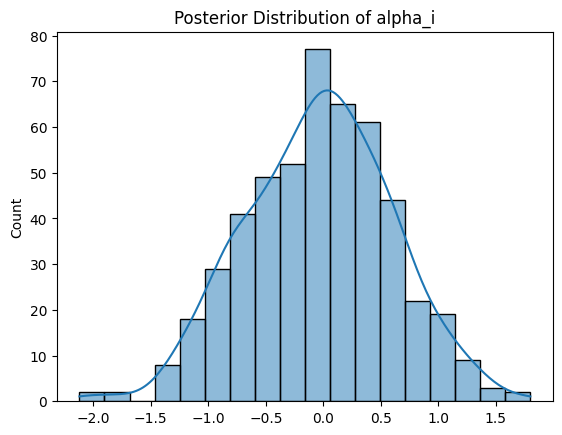

In [47]:
# extract alpha_i coefficients from mcmc samples
alpha_i_samples = post_samples["alpha_i"]

# put in df
alpha_i_samples = pd.DataFrame(alpha_i_samples[0])
alpha_i_samples.head()

# Plot the posterior distribution of alpha_i
fig, ax = plt.subplots()
sns.histplot(alpha_i_samples.values.flatten(), ax=ax, kde=True)
ax.set_title("Posterior Distribution of alpha_i")
plt.show()


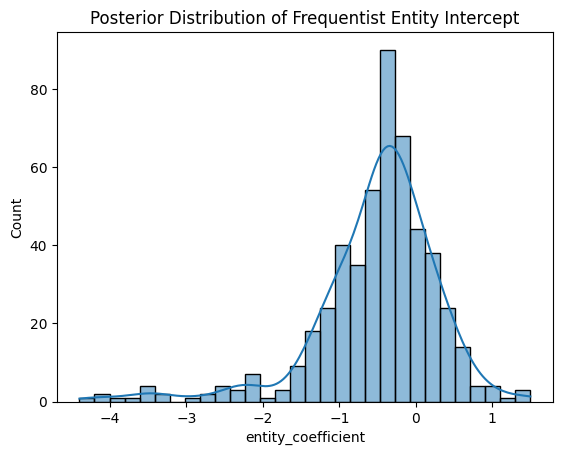

In [ ]:
# make similar histplot for entity_coefficient column of entity_effects df from classical fixed effects regression
fig, ax = plt.subplots()
sns.histplot(entity_effects["entity_coefficient"], ax=ax, kde=True)
ax.set_title("Posterior Distribution of Frequentist Entity Intercept")

plt.show()

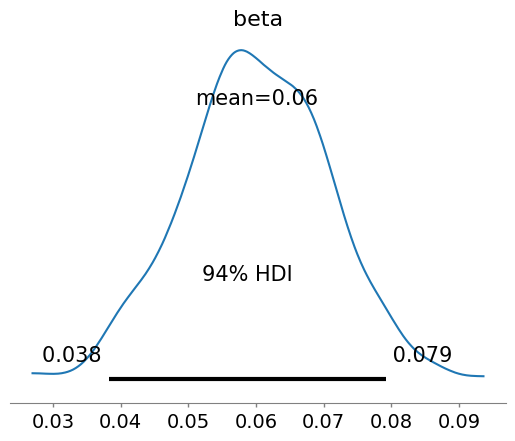

In [49]:
# Plot posterior distributions
az.plot_posterior(azMCMC, var_names=["beta"])
plt.show()

**Plot LANDKREIS color-coded dots of alpha_mean to see Regional distribution of intercepts**

In [69]:
# Select the 'CELLCODE' and 'LANDKREIS' columns from the farm_field DataFrame
farm_field_selected = farm_field[['CELLCODE', 'LANDKREIS']].drop_duplicates()

# Merge the selected columns with the entity_effects DataFrame on the 'CELLCODE' column
# entity_effectsl = pd.merge(entity_effects, farm_field_selected, on='CELLCODE', how='left')

#Merge the selected columns withe the df_alpha DataFrame on the 'CELLCODE' column
alpha_cells = pd.merge(df_alpha, farm_field_selected, on='CELLCODE', how='left')

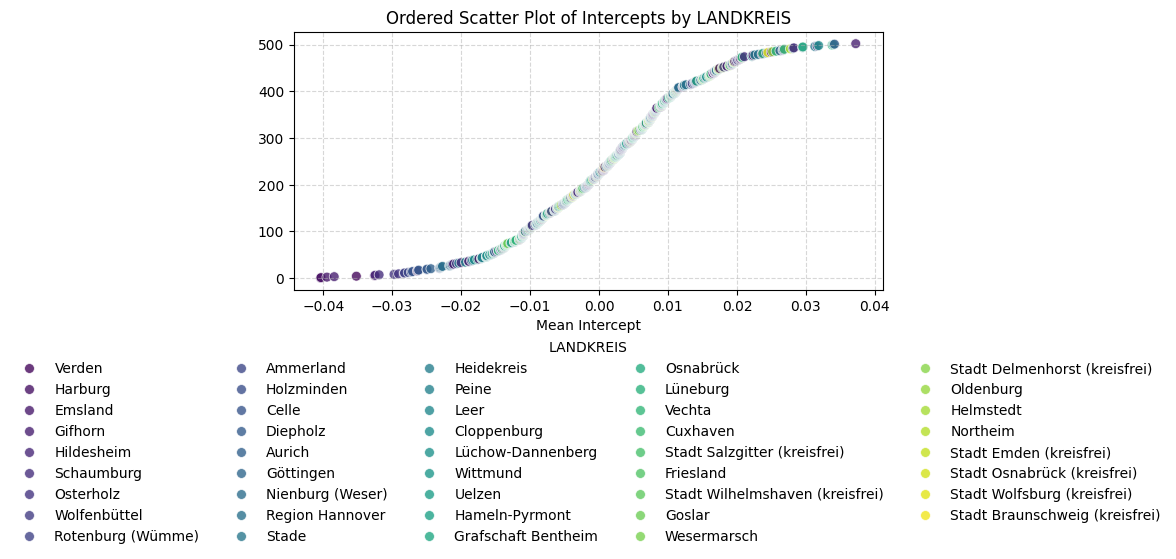

In [ ]:
# Sort by mean for better visualization
alpha_cells = alpha_cells.sort_values(by='mean')

# Create a simple scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=alpha_cells, 
    x='mean', 
    y=range(len(alpha_cells)),  # Just rank entities, no entity labels
    hue='LANDKREIS', 
    palette='viridis', 
    s=50,  # Make dots smaller
    alpha=0.8
)

plt.xlabel('Mean Intercept')
plt.ylabel('')  # Remove y-axis label
plt.title('Ordered Scatter Plot of Intercepts by LANDKREIS')

# Customize legend: Place it below the plot in 5 rows
plt.legend(
    title='LANDKREIS', 
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15),  # Moves legend below the plot
    ncol=5,  # Arrange in 5 columns
    frameon=False  # Remove legend box
)

plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()  # Adjust layout to fit everything well

plt.show()


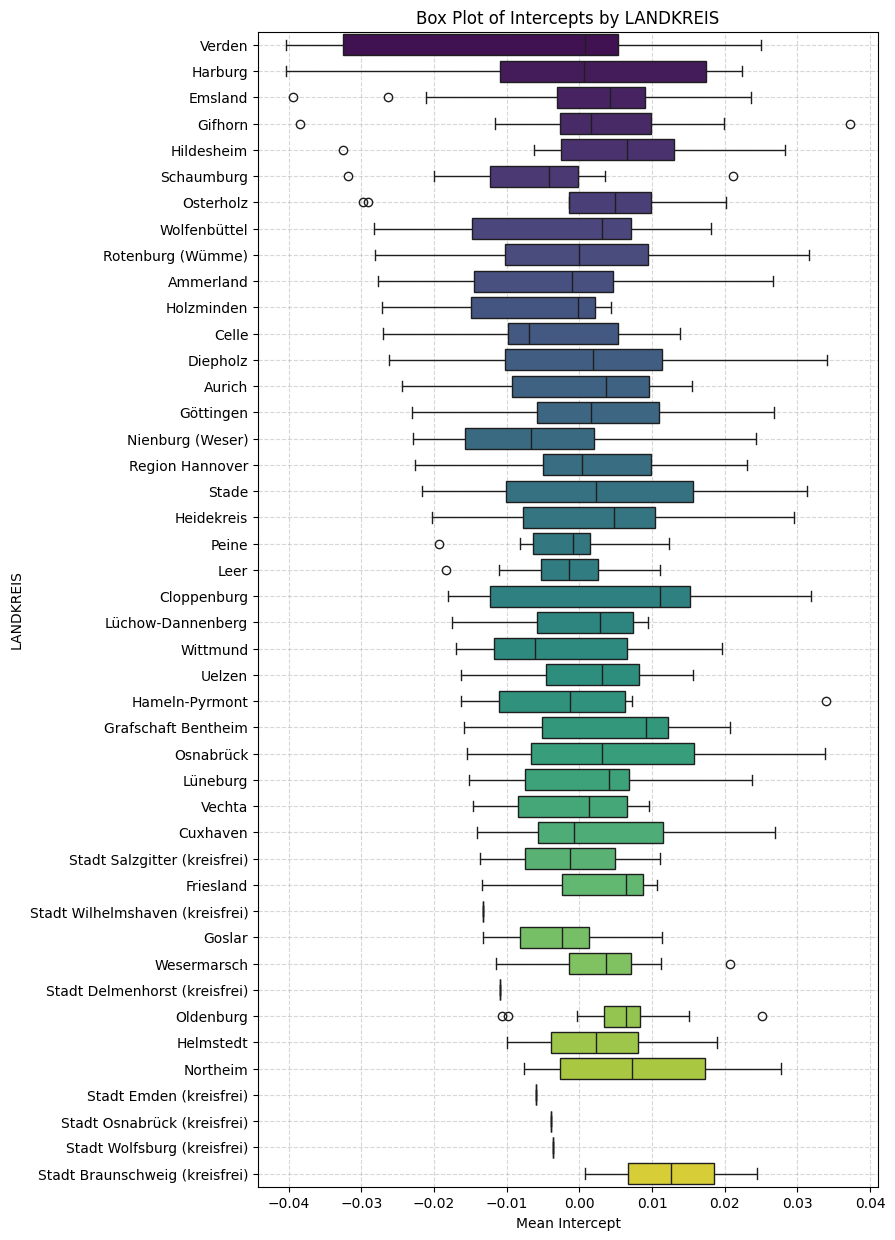

In [ ]:
plt.figure(figsize=(8, 15))
sns.boxplot(data=alpha_cells, x='mean', y='LANDKREIS', hue='LANDKREIS', dodge=False, palette='viridis')

plt.xlabel('Mean Intercept')
plt.ylabel('LANDKREIS')
plt.title('Box Plot of Intercepts by LANDKREIS')
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()
